## Определение возможной оценки отзыва по пятибальной шкале

## Загрузка набора данных

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip -O glove.twitter.27B.zip

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz -O yelp_review_full_csv.tgz

--2020-08-10 08:08:25--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.166.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.166.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196146755 (187M) [application/x-tar]
Saving to: ‘yelp_review_full_csv.tgz’

yelp_review_full_cs 100%[===================>] 187.06M  16.4MB/s    in 13s     

2020-08-10 08:08:39 (14.5 MB/s) - ‘yelp_review_full_csv.tgz’ saved [196146755/196146755]



In [ ]:
!unzip glove.twitter.27B.zip

unzip:  cannot find or open glove.twitter.27B.zip, glove.twitter.27B.zip.zip or glove.twitter.27B.zip.ZIP.


In [ ]:
!tar -xvf yelp_review_full_csv.tgz

yelp_review_full_csv/
yelp_review_full_csv/train.csv
yelp_review_full_csv/readme.txt
yelp_review_full_csv/test.csv


## Начало

In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [ ]:
# векторы слов GLoVe, чтобы получить предварительно обученные вложения слов
embed_size = 100 
# максимальное количество уникальных слов 
max_features = 10000
# максимальное количество слов из отзыва для использования
maxlen = 100

## Считываем данные

In [ ]:
train = pd.read_csv('yelp_review_full_csv/train.csv', 
                    header=None, 
                    names=['stars', 'text'])
test=pd.read_csv('yelp_review_full_csv/test.csv', 
                    header=None, 
                    names=['stars', 'text'])

In [ ]:
train.shape, test.shape

((650000, 2), (50000, 2))

,text,stars
0,dr. goldberg offers everything i look for in a...,5
1,"Unfortunately, the frustration of being Dr. Go...",2
2,Been going to Dr. Goldberg for over 10 years. ...,4
3,Got a letter in the mail last week that said D...,4
4,I don't know what Dr. Goldberg was like before...,1


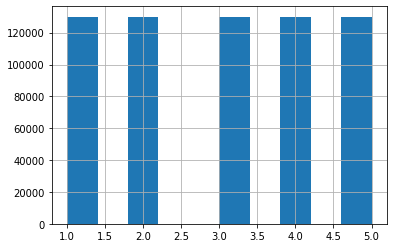

In [ ]:
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [ ]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
0,dr. goldberg offers everything i look for in a...,0,0,0,0,1
1,"Unfortunately, the frustration of being Dr. Go...",0,1,0,0,0
2,Been going to Dr. Goldberg for over 10 years. ...,0,0,0,1,0
3,Got a letter in the mail last week that said D...,0,0,0,1,0
4,I don't know what Dr. Goldberg was like before...,1,0,0,0,0


In [ ]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((650000, 6), (50000, 6))

Перемешиваем данные

In [ ]:
train_samp = train.sample(frac = 1., random_state = 42)
test_samp = test.sample(frac = 1., random_state = 42)
train_samp.shape, test_samp.shape

((650000, 6), (50000, 6))

Создаем вектор ответов y

In [ ]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
y = train_samp[class_names].values

Обучаем токенезатор слов

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

# сохранение
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Загружаем модели заранее обученых английских  слов.

In [ ]:
# # Файл патч
# embedding_file = '/content/glove.twitter.27B.100d.txt'

#  # читать во вложениях
# def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [ ]:
# word_index = tokenizer.word_index

# nb_words = min(max_features, len(word_index))
# # создаем матрицу нулей правильных размеров 
# embedding_matrix = np.zeros((nb_words, embed_size))
# missed = []
# for word, i in word_index.items():
#     if i >= max_features: break
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector
#     else:
#         missed.append(word)
# #print(len(missed))
# #print(missed[0:10])
# #print(missed[len(missed)-10:len(missed)])

## Создаем и обучаем модель

Создаем модель

In [ ]:
inp = Input(shape = (maxlen,))
#x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = Embedding(max_features, embed_size)(inp) # без использования обученого словаря
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
#Остановка обучения и сохранения лучших весов.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3) # patience - это сколько эпох ждать, чтобы увидеть, улучшится ли val_loss снова.
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.fit(x_train, y, batch_size = 512, epochs = 5, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Epoch 1/5
1143/1143 [==============================] - 141s 123ms/step - loss: 0.3608 - accuracy: 0.5288 - val_loss: 0.3239 - val_accuracy: 0.5932
Epoch 2/5
1143/1143 [==============================] - 138s 120ms/step - loss: 0.3182 - accuracy: 0.5998 - val_loss: 0.3101 - val_accuracy: 0.6112
Epoch 3/5
1143/1143 [==============================] - 138s 121ms/step - loss: 0.3070 - accuracy: 0.6174 - val_loss: 0.3071 - val_accuracy: 0.6165
Epoch 4/5
1143/1143 [==============================] - 137s 120ms/step - loss: 0.3009 - accuracy: 0.6272 - val_loss: 0.3046 - val_accuracy: 0.6197
Epoch 5/5
1143/1143 [==============================] - 138s 121ms/step - loss: 0.2963 - accuracy: 0.6348 - val_loss: 0.3032 - val_accuracy: 0.6211


## Тест модели

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
model=load_model("yelp_lstm_gru_weights.hdf5")

In [ ]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

49/49 [==============================] - 3s 62ms/step - loss: 0.3058 - accuracy: 0.6154


[0.30580365657806396, 0.6154400110244751]

## Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is really bad and very expensive.  The host and waiters are rude. 
I will never visit the SmartBurger again!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
data = pad_sequences(sequence, maxlen=100)

In [ ]:
result = model.predict(data)

In [ ]:
result

array([[9.2860466e-01, 5.9708517e-02, 3.9468687e-03, 3.5595539e-04,
        2.4922373e-04]], dtype=float32)